In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
#plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
plotsize_subplots = (16,3)

fontsize_axis = 9
fontsize_labels = 9
fontsize_legends = 8

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    
    # For MAM, T_conns is divided into T_network_global and T_connect:
    if 'T_conns_min' not in list(df) and 'T_network_global_min' in list(df): 
        df['T_conns_min'] = df['T_network_global_min'] + df['T_connect_min']
        df['T_conns_max'] = df['T_network_global_max'] + df['T_connect_max']
    
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum

    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)

    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [5]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None, plot_T_sim=True, plot_kind='bar', title=''):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    if plot_T_sim:
        df['Simulation time'] = df['T_sim']
        values.insert(3, 'Simulation time')
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        if len(values) == 1:
            axes = [axes]
                
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind=plot_kind, ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    if title:
        fig.suptitle(title, y=1.2)
            
    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

# Benchmarks

## SLI BENCHMARKS

## HPC benchmark - weak scaling

Conn. Creation (min)                      \
Case NEST 3.0 (6885724bb - colocate) NEST 3.0 (d4d1b3f5)   
N_VP                                                       
36                             54.87               56.68   
72                             55.07               56.61   
144                            55.13               56.78   
288                            55.76               57.12   
576                            56.51               57.74   
1152                           57.80               59.17   

                Conn. Exchange (min)                      \
Case NEST 3.0 (6885724bb - colocate) NEST 3.0 (d4d1b3f5)   
N_VP                                                       
36                             83.40               83.42   
72                             84.68               83.81   
144                            85.04               84.20   
288                            87.65               87.73   
576                            90.59               89.33   
1152                           94.80               94.54   

                         Conn. Total                      \
Case NEST 3.0 (6885724bb - colocate) NEST 3.0 (d4d1b3f5)   
N_VP                                                       
36                            143.50              151.60   
72                            144.77              151.18   
144                           146.47              155.97   
288                           150.49              160.64   
576                           153.60              162.79   
1152                          159.53              169.86   

                       Memory per VP                      \
Case NEST 3.0 (6885724bb - colocate) NEST 3.0 (d4d1b3f5)   
N_VP                                                       
36                          2.891932            2.889483   
72                          2.895959            2.896359   
144                         2.981876            2.980770   
288                         2.985496            2.985183   
576                         3.077996            3.074415   
1152                        3.452555            3.450920   

                     Simulation time                      
Case NEST 3.0 (6885724bb - colocate) NEST 3.0 (d4d1b3f5)  
N_VP                                                      
36                            210.76              206.47  
72                            213.35              213.47  
144                           216.48              212.72  
288                           229.42              224.68  
576                           244.27              241.41  
1152                          281.98              283.97

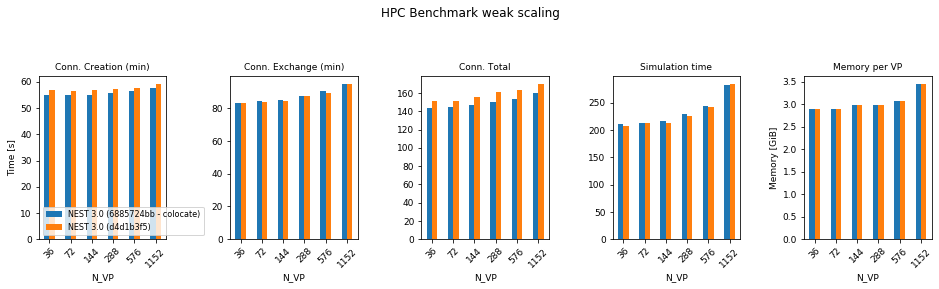

In [16]:
hpc_3_d4 = pd.read_csv('results/hpc_benchmark_3_0_d4d1b3f59_daint.csv')
hpc_3_d4['Case'] = ['NEST 3.0 (d4d1b3f5)'] * len(hpc_3_d4)

hpc_3_colocate = pd.read_csv('results/colocate/hpc_benchmark_3_0_6885724bb_colocate_daint.csv')
hpc_3_colocate['Case'] = ['NEST 3.0 (6885724bb - colocate)'] * len(hpc_3_colocate)

hpc = pd.concat([hpc_3_d4, hpc_3_colocate])

hpc = calculate_T_conn_and_memory(hpc)
hpc_p = plot_compare(hpc, 'figures/colocate/hpc_benchmark_weak_scaling.pdf', legend_loc='lower left',
                     title='HPC Benchmark weak scaling')

hpc_p

## 4x4 mesocircuit weak scaling

Conn. Creation (min)                       \
Case NEST 3.0 (6885724bb - colocate) NEST 3.0 (d4d1b3f59)   
N_VP                                                        
36                            182.55               174.45   
72                            188.64               179.64   
144                           228.09               219.76   
288                           326.70               318.90   
576                           527.84               523.86   
1152                          953.75               953.30   

                Conn. Exchange (min)                       \
Case NEST 3.0 (6885724bb - colocate) NEST 3.0 (d4d1b3f59)   
N_VP                                                        
36                             12.10                14.54   
72                             12.32                12.35   
144                            13.04                13.10   
288                            14.85                14.28   
576                            17.56                16.15   
1152                           20.48                20.21   

                         Conn. Total                       \
Case NEST 3.0 (6885724bb - colocate) NEST 3.0 (d4d1b3f59)   
N_VP                                                        
36                            194.65               189.00   
72                            200.98               192.01   
144                           241.16               232.91   
288                           341.59               333.25   
576                           545.48               540.17   
1152                          974.34               973.93   

                       Memory per VP                       \
Case NEST 3.0 (6885724bb - colocate) NEST 3.0 (d4d1b3f59)   
N_VP                                                        
36                          0.741542             0.740720   
72                          0.763690             0.757958   
144                         0.830482             0.830569   
288                         0.819691             0.821914   
576                         0.925466             0.928039   
1152                        1.257119             1.253380   

                     Simulation time                       
Case NEST 3.0 (6885724bb - colocate) NEST 3.0 (d4d1b3f59)  
N_VP                                                       
36                             44.39                42.67  
72                             52.22                51.69  
144                            88.46                82.70  
288                           176.73               164.35  
576                           330.28               319.15  
1152                          674.81               691.60

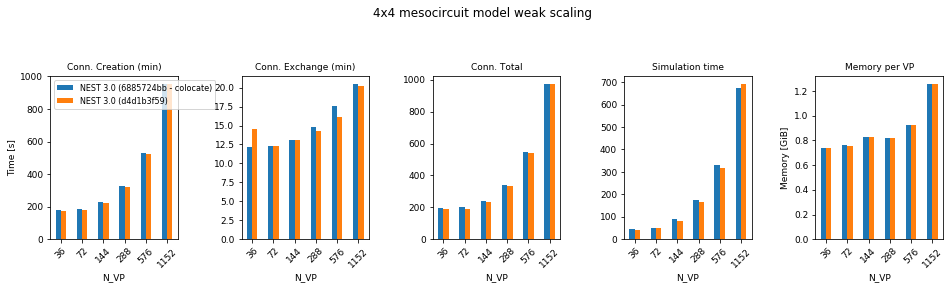

In [21]:
meso_3_d4 = pd.read_csv('results/4x4_mesocircuit_3_0_d4d1b3f59_daint.csv')
meso_3_d4['Case'] = ['NEST 3.0 (d4d1b3f59)'] * len(meso_3_d4)

meso_3_colocate = pd.read_csv('results/colocate/4x4_mesocircuit_3_0_6885724bb_colocate_daint.csv')
meso_3_colocate['Case'] = ['NEST 3.0 (6885724bb - colocate)'] * len(meso_3_colocate)

meso = pd.concat([meso_3_d4, meso_3_colocate])

meso = calculate_T_conn_and_memory(meso)

meso_p = plot_compare(meso, 'figures/colocate/4x4_mesocircuit_weak_scaling.pdf',
                      legend_loc='upper left',
                      title='4x4 mesocircuit model weak scaling')
meso_p

## HPC Benchmark strong scaling

Conn. Creation (min)                       \
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (d4d1b3f59)   
num_tasks                                                      
6                                  0.71                 0.74   
12                                 0.36                 0.38   
24                                 0.19                 0.19   
48                                 0.10                 0.10   
96                                 0.05                 0.06   
192                                0.03                 0.03   
384                                0.02                 0.02   
768                                0.02                 0.02   

                   Conn. Exchange (min)                       \
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (d4d1b3f59)   
num_tasks                                                      
6                                  1.16                 1.18   
12                                 0.67                 0.69   
24                                 0.36                 0.38   
48                                 0.32                 0.35   
96                                 0.13                 0.13   
192                                0.25                 0.23   
384                                0.27                 0.10   
768                                0.26                 0.19   

                            Conn. Total                       \
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (d4d1b3f59)   
num_tasks                                                      
6                                  1.97                 2.19   
12                                 1.09                 1.20   
24                                 0.58                 0.65   
48                                 0.44                 0.52   
96                                 0.20                 0.21   
192                                0.78                 0.60   
384                                0.62                 0.46   
768                                0.61                 0.69   

                        Memory per task                       \
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (d4d1b3f59)   
num_tasks                                                      
6                              1.106150             1.125310   
12                             1.020044             1.010558   
24                             0.927878             0.935441   
48                             1.126977             1.127562   
96                             0.843222             0.843796   
192                            0.808629             0.809051   
384                            0.811137             0.810186   
768                            0.812373             0.811496   

                        Simulation time                       
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (d4d1b3f59)  
num_tasks                                                     
6                                  7.59                 7.39  
12                                 4.06                 4.00  
24                                 2.38                 2.44  
48                                 5.76                 5.68  
96                                 1.60                 1.73  
192                                2.27                 1.74  
384                                1.71                 1.58  
768                                2.15                 2.11

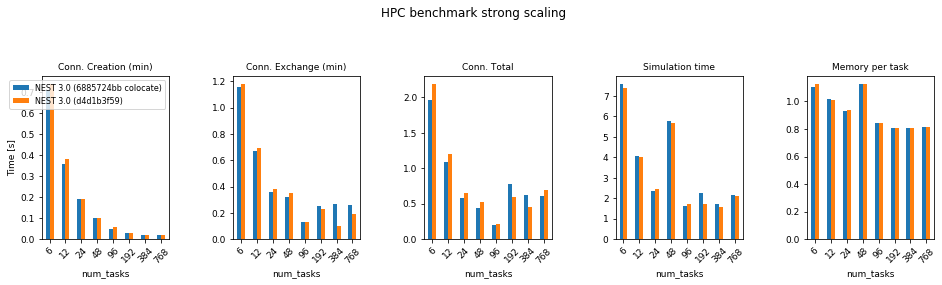

In [22]:
hpc_strong_3_d4 = pd.read_csv('results/hpc_benchmark_3_0_d4d1b3f59_daint_strong_scaling.csv')
hpc_strong_3_d4['Case'] = ['NEST 3.0 (d4d1b3f59)'] * len(hpc_strong_3_d4)

hpc_strong_3_colocate = pd.read_csv('results/colocate/hpc_benchmark_3_0_6885724bb_colocate_daint_strong_scaling.csv')
hpc_strong_3_colocate['Case'] = ['NEST 3.0 (6885724bb colocate)'] * len(hpc_strong_3_colocate)

hpc_strong = pd.concat([hpc_strong_3_d4, hpc_strong_3_colocate])

hpc_strong = calculate_T_conn_and_memory(hpc_strong)
hpc_strong['Memory per task'] = (hpc_strong['VSize_sum']/hpc_strong['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
hpc_strong_p = plot_compare(hpc_strong, 'figures/colocate/hpc_benchmark_strong_scaling.pdf',
                            values=values, index='num_tasks',
                            legend_loc='upper right',
                            title='HPC benchmark strong scaling')

hpc_strong_p

## PYNEST BENCHMARK

## Population benchmark, weak scaling

Conn. Creation (min)                       \
Case NEST 3.0 (6885724bb colocate) NEST 3.0 (d4d1b3f59)   
N_VP                                                      
36                       38.907994            37.814978   
72                       58.096431            57.237079   
144                      75.054723            74.860522   
288                     109.143455           110.440211   
576                     179.767834           184.100347   
1152                    318.219147           328.702197   

                                                             \
Case NEST 3.0 (e782bff22 colocate) NEST 3.0 (m - 54c206f7b)   
N_VP                                                          
36                       77.003936                62.013594   
72                       88.878571                73.242557   
144                     110.599530                94.944250   
288                     154.795105               138.335378   
576                            NaN                      NaN   
1152                           NaN                      NaN   

              Conn. Exchange (min)                       \
Case NEST 3.0 (6885724bb colocate) NEST 3.0 (d4d1b3f59)   
N_VP                                                      
36                       48.363969            46.166910   
72                       62.101748            60.055593   
144                      60.474072            59.003475   
288                      60.814928            62.322652   
576                      65.509342            65.055323   
1152                     79.474867            79.499960   

                                                             \
Case NEST 3.0 (e782bff22 colocate) NEST 3.0 (m - 54c206f7b)   
N_VP                                                          
36                       76.965118                72.553550   
72                       77.821819                75.527940   
144                      79.147281                79.277738   
288                      80.015439                79.923181   
576                            NaN                      NaN   
1152                           NaN                      NaN   

                       Conn. Total                       \
Case NEST 3.0 (6885724bb colocate) NEST 3.0 (d4d1b3f59)   
N_VP                                                      
36                       93.986696            86.836908   
72                      127.660074           120.756229   
144                     143.904198           136.946882   
288                     180.165158           177.569097   
576                     255.661691           256.661156   
1152                    416.611037           424.827691   

                                                             \
Case NEST 3.0 (e782bff22 colocate) NEST 3.0 (m - 54c206f7b)   
N_VP                                                          
36                      173.131528               150.155794   
72                      186.180174               163.298762   
144                     208.989390               189.336728   
288                     255.658927               234.553256   
576                            NaN                      NaN   
1152                           NaN                      NaN   

                     Memory per VP                       \
Case NEST 3.0 (6885724bb colocate) NEST 3.0 (d4d1b3f59)   
N_VP                                                      
36                        2.312954             2.292113   
72                        3.021245             3.021241   
144                       3.104599             3.104603   
288                       3.099027             3.099025   
576                       3.102025             3.102018   
1152                      3.102768             3.102778   

                                                             
Case NEST 3.0 (e782bff22 colocate) NEST 3.0 (m - 54c206f7b)  
N_VP                                                      

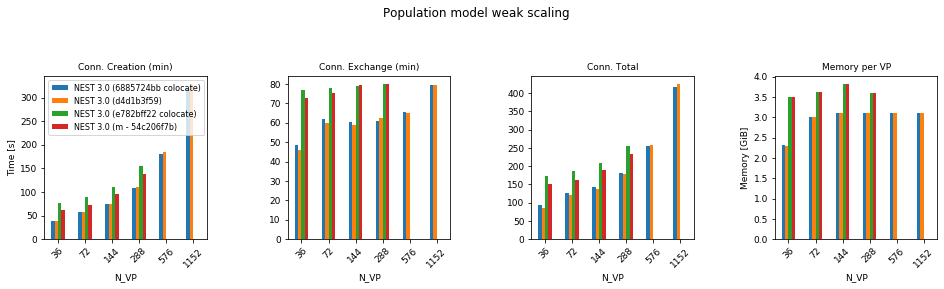

In [15]:
population_s4_3_d4 = pd.read_csv('results/population_model_3_0_d4d1b3f59_daint_in_scale4.csv')
population_s4_3_d4['Case'] = ['NEST 3.0 (d4d1b3f59)'] * len(population_s4_3_d4)

population_s4_3_colocate = pd.read_csv('results/colocate/population_model_3_0_6885724bb_colocate_daint_in_scale4.csv')
population_s4_3_colocate['Case'] = ['NEST 3.0 (6885724bb colocate)'] * len(population_s4_3_colocate)
population_s4_3_col_e7 = pd.read_csv('results/colocate/population_model_3_0_e782bff22_colocate_daint_in_scale4.csv')
population_s4_3_col_e7['Case'] = ['NEST 3.0 (e782bff22 colocate)'] * len(population_s4_3_col_e7)

population_s4_3_54 = pd.read_csv('results/colocate/population_model_3_0_54c206f7b_daint_in_scale4.csv')
population_s4_3_54['Case'] = ['NEST 3.0 (m - 54c206f7b)'] * len(population_s4_3_54)

population_s4 = pd.concat([population_s4_3_d4, population_s4_3_colocate, population_s4_3_col_e7, population_s4_3_54])

population_s4 = calculate_T_conn_and_memory(population_s4)
population_s4_p = plot_compare(population_s4, 'figures/colocate/population_model_weak_scaling_scale4.pdf',
                               ['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                                'Memory per VP'],
                               plot_T_sim=False, legend_loc='upper left',
                               title='Population model weak scaling')

population_s4_p

## Population bencmark, strong scaling

Conn. Creation (min)                       \
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (d4d1b3f59)   
num_tasks                                                      
12                            72.659533            71.659769   
24                            46.922982            46.819822   
48                            34.096048            34.505664   
96                            28.114949            28.801075   
192                           24.854763            25.651576   
384                           23.032849            23.934190   
768                           21.866330            22.823735   

                   Conn. Exchange (min)                       \
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (d4d1b3f59)   
num_tasks                                                      
12                            75.811543            75.602642   
24                            37.798106            38.112961   
48                            20.417480            19.759765   
96                            10.855162            10.829389   
192                            5.766762             6.057964   
384                            4.788838             5.765935   
768                            2.586633             2.608972   

                            Conn. Total                       \
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (d4d1b3f59)   
num_tasks                                                      
12                           157.815814           151.492076   
24                            89.820111            86.777802   
48                            57.529552            56.238982   
96                            40.793840            41.285251   
192                           32.619911            33.335833   
384                           29.453799            31.190920   
768                           26.406380            27.837070   

                        Memory per task                       
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (d4d1b3f59)  
num_tasks                                                     
12                            21.776481            21.776435  
24                            12.203421            12.281500  
48                             7.170332             7.170287  
96                             4.596609             4.607143  
192                            3.573313             3.573756  
384                            2.849842             2.851841  
768                            2.322692             2.320660

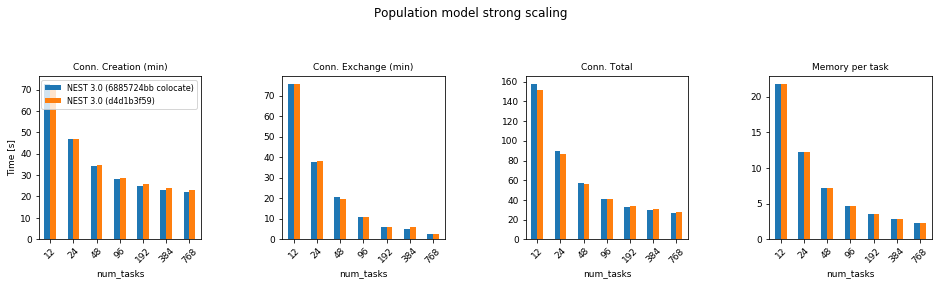

In [25]:
pop_strong_3 = pd.read_csv('results/population_model_3_0_d4d1b3f59_daint_strong_scaling_in.csv')
pop_strong_3['Case'] = ['NEST 3.0 (d4d1b3f59)'] * len(pop_strong_3)

pop_strong_3_colocate = pd.read_csv('results/colocate/population_model_3_0_6885724bb_colocate_daint_strong_scaling_in.csv')
pop_strong_3_colocate['Case'] = ['NEST 3.0 (6885724bb colocate)'] * len(pop_strong_3_colocate)

population_strong = pd.concat([pop_strong_3, pop_strong_3_colocate])

population_strong = calculate_T_conn_and_memory(population_strong)
population_strong['Memory per task'] = (population_strong['VSize_sum']/population_strong['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
population_strong_p = plot_compare(population_strong, 'figures/colocate/population_model_strong_scaling.pdf', values=values,
                                   index='num_tasks', plot_T_sim=False, legend_loc='upper right',
                                   title='Population model strong scaling')

population_strong_p

## Colocate benchmark, weak scaling

Conn. Creation (min)                                   \
Case NEST 3.0 (6885724bb colocate) NEST 3.0 (6885724bb no colocate)   
N_VP                                                                  
36                       32.240653                        38.559557   
72                       42.893550                        57.209405   
144                      47.918999                        74.364785   
288                      58.551960                       108.635338   
576                      78.809734                       179.284185   
1152                    120.283371                       318.244408   

                                                                         \
Case NEST 3.0 (d4d1b3f59 (m) no colocate) NEST 3.0 (e782bff22 colocate)   
N_VP                                                                      
36                              37.753368                     40.769157   
72                              56.607433                     53.521008   
144                             74.431536                     59.085878   
288                            110.337347                     69.862263   
576                            183.939633                     91.325722   
1152                           329.092308                    135.506494   

                                               Conn. Exchange (min)  \
Case NEST 3.0 (e782bff22 no colocate) NEST 3.0 (6885724bb colocate)   
N_VP                                                                  
36                          46.634900                     49.301378   
72                          67.448359                     59.776954   
144                         84.872910                     60.748362   
288                        120.850657                     62.396903   
576                        194.748234                     64.226048   
1152                       338.820679                     66.992121   

                                                                            \
Case NEST 3.0 (6885724bb no colocate) NEST 3.0 (d4d1b3f59 (m) no colocate)   
N_VP                                                                         
36                          47.909812                            46.932919   
72                          59.858176                            59.697873   
144                         62.364526                            60.365052   
288                         61.677782                            62.177181   
576                         64.707552                            63.842807   
1152                        67.864405                            67.503156   

                                                                     \
Case NEST 3.0 (e782bff22 colocate) NEST 3.0 (e782bff22 no colocate)   
N_VP                                                                  
36                       49.625116                        47.411097   
72                       61.053434                        62.782076   
144                      63.277872                        62.993202   
288                      62.863958                        63.307375   
576                      64.795645                        65.787502   
1152                     69.923579                        69.740128   

                       Conn. Total                                   \
Case NEST 3.0 (6885724bb colocate) NEST 3.0 (6885724bb no colocate)   
N_VP                                                                  
36                       85.713262                        89.797453   
72                      108.257288                       120.884798   
144                     114.138619                       142.458081   
288                     126.570256                       176.879356   
576                     148.631942                       252.643286   
1152                    196.105568                       402.606326   

                                                                         \


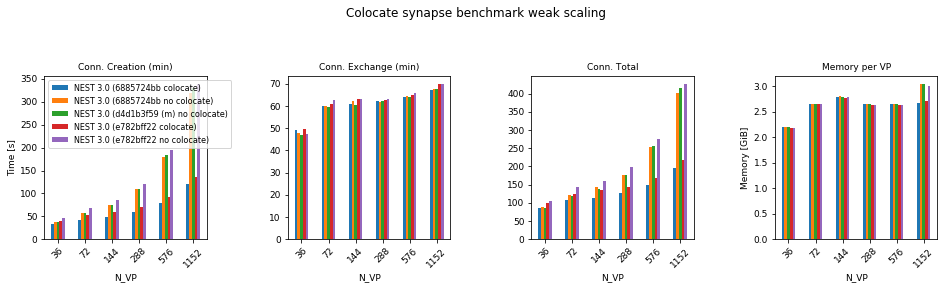

In [8]:
colocate_68 = pd.read_csv('results/colocate/colocate_synapse_benchmark_6885724bb_daint.csv')
colocate_68['Case'] = ['NEST 3.0 (6885724bb colocate)'] * len(colocate_68)

colocate_e7 = pd.read_csv('results/colocate/colocate_synapse_benchmark_e782bff22_daint.csv')
colocate_e7['Case'] = ['NEST 3.0 (e782bff22 colocate)'] * len(colocate_e7)

no_colocate_68 = pd.read_csv('results/colocate/colocate_synapse_benchmark_6885724bb_no_colocate_daint.csv')
no_colocate_68['Case'] = ['NEST 3.0 (6885724bb no colocate)'] * len(no_colocate_68)

no_colocate_e7 = pd.read_csv('results/colocate/colocate_synapse_benchmark_e782bff22_no_colocate_daint.csv')
no_colocate_e7['Case'] = ['NEST 3.0 (e782bff22 no colocate)'] * len(no_colocate_e7)

no_colocate_d4 = pd.read_csv('results/colocate/colocate_synapse_benchmark_d4d1b3f59_no_colocate_daint.csv')
no_colocate_d4['Case'] = ['NEST 3.0 (d4d1b3f59 (m) no colocate)'] * len(no_colocate_d4)

colocate = pd.concat([colocate_68, no_colocate_68, no_colocate_d4, colocate_e7, no_colocate_e7])

colocate = calculate_T_conn_and_memory(colocate)
colocate_p = plot_compare(colocate, 'figures/colocate/colocate_synapse_benchmark_weak_scaling.pdf',
                          ['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP'],
                          plot_T_sim=False, legend_loc='upper left',
                          title='Colocate synapse benchmark weak scaling')

colocate_p

## Spatial colocate benchmark, weak scaling

Conn. Creation (min)                                \
Case NEST 3.0 (54c206f7b (m) no colocate) NEST 3.0 (e782bff22 colocate)   
N_VP                                                                      
36                             181.929182                    206.940553   
72                             254.695794                    290.991467   
144                            248.241125                    315.681090   
288                            282.794091                    330.611341   
576                            355.720994                    357.701881   
1152                           584.734775                    521.467380   

                                                      Conn. Exchange (min)  \
Case NEST 3.0 (e782bff22 no colocate) NEST 3.0 (54c206f7b (m) no colocate)   
N_VP                                                                         
36                         159.148687                            49.355389   
72                         251.092347                            63.420532   
144                        250.019766                            62.506818   
288                        286.221194                            62.787798   
576                        356.339895                            63.797204   
1152                       596.846550                            87.180813   

                                                                     \
Case NEST 3.0 (e782bff22 colocate) NEST 3.0 (e782bff22 no colocate)   
N_VP                                                                  
36                       50.023114                        48.558410   
72                       63.258616                        63.915982   
144                      62.758833                        63.215378   
288                      64.349465                        63.369220   
576                      65.113539                        65.859183   
1152                     81.843714                        88.383502   

                              Conn. Total                                \
Case NEST 3.0 (54c206f7b (m) no colocate) NEST 3.0 (e782bff22 colocate)   
N_VP                                                                      
36                             232.756338                    257.571154   
72                             319.428621                    354.881229   
144                            311.145619                    378.874739   
288                            345.784180                    395.178158   
576                            419.696850                    422.932071   
1152                           672.154515                    603.556283   

                                                             Memory per VP  \
Case NEST 3.0 (e782bff22 no colocate) NEST 3.0 (54c206f7b (m) no colocate)   
N_VP                                                                         
36                         208.762764                             2.188943   
72                         315.967843                             2.919255   
144                        313.568735                             2.827375   
288                        349.748692                             2.727991   
576                        422.294061                             2.770515   
1152                       685.469882                             3.153494   

                                                                     
Case NEST 3.0 (e782bff22 colocate) NEST 3.0 (e782bff22 no colocate)  
N_VP                                                                 
36                        2.286626                         2.206324  
72                        2.720426                         2.915779  
144                       2.613221                         2.832584  
288                       2.561026                         2.733161  
576                       2.706022                         2.769499  
1152                      2.967731                         3.15

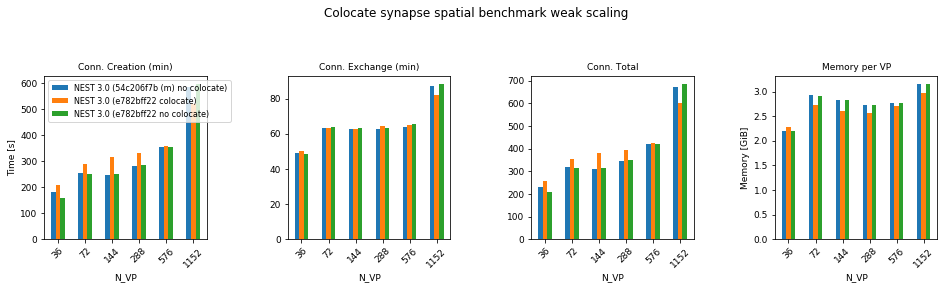

In [16]:
colocate_sp_e7 = pd.read_csv('results/colocate/colocate_synapse_benchmark_e782bff22_spatial_daint.csv')
colocate_sp_e7['Case'] = ['NEST 3.0 (e782bff22 colocate)'] * len(colocate_sp_e7)

no_colocate_sp_e7 = pd.read_csv('results/colocate/colocate_synapse_benchmark_e782bff22_no_colocate_spatial_daint.csv')
no_colocate_sp_e7['Case'] = ['NEST 3.0 (e782bff22 no colocate)'] * len(no_colocate_sp_e7)

no_colocate_sp_54 = pd.read_csv('results/colocate/colocate_synapse_benchmark_54c206f7b_no_colocate_spatial_daint.csv')
no_colocate_sp_54['Case'] = ['NEST 3.0 (54c206f7b (m) no colocate)'] * len(no_colocate_sp_54)

colocate_sp = pd.concat([colocate_sp_e7, no_colocate_sp_e7, no_colocate_sp_54])

colocate_sp = calculate_T_conn_and_memory(colocate_sp)
colocate_sp_p = plot_compare(colocate_sp, 'figures/colocate/colocate_synapse_spatial_benchmark_weak_scaling.pdf',
                             ['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP'],
                             plot_T_sim=False, legend_loc='upper left',
                             title='Colocate synapse spatial benchmark weak scaling')

colocate_sp_p

## Colocate benchmark, strong scaling

Conn. Creation (min)                                   \
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (6885724bb no colocate)   
num_tasks                                                                  
12                            53.669137                        71.507357   
24                            29.932962                        46.476181   
48                            18.289825                        33.941570   
96                            12.302838                        27.990216   
192                            9.387279                        24.841942   
384                            7.885992                        23.080981   
768                            6.992039                        21.985019   

                                                                          \
Case      NEST 3.0 (d4d1b3f59 no colocate) NEST 3.0 (e782bff22 colocate)   
num_tasks                                                                  
12                               70.645745                     66.777760   
24                               46.455853                     36.731464   
48                               34.398901                     21.839671   
96                               28.698954                     14.214045   
192                              25.690369                     10.597063   
384                              23.997896                      8.711177   
768                              22.909042                      7.575526   

                   Conn. Exchange (min)                                   \
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (6885724bb no colocate)   
num_tasks                                                                  
12                            74.098893                        74.675687   
24                            38.713022                        38.618782   
48                            19.459636                        19.967644   
96                            11.430205                        11.391678   
192                            7.776948                         8.135638   
384                            4.447700                         4.410402   
768                            2.181376                         2.517493   

                                                                          \
Case      NEST 3.0 (d4d1b3f59 no colocate) NEST 3.0 (e782bff22 colocate)   
num_tasks                                                                  
12                               75.285660                     77.099442   
24                               38.352532                     39.710514   
48                               19.981271                     20.274352   
96                               11.825081                     11.737043   
192                               8.082450                      8.180690   
384                               4.393514                      4.341125   
768                               2.517839                      2.201847   

                            Conn. Total                                   \
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (6885724bb no colocate)   
num_tasks                                                                  
12                           134.642328                       151.193085   
24                            72.094137                        88.110373   
48                            39.509084                        56.006346   
96                            24.646935                        40.792174   
192                           17.909663                        34.489950   
384                           12.879265                        29.443845   
768                            9.716183                        26.023141   

                                                                          \
Case      NEST 3.0 (d4d1b3f59 no colocate) NEST 3.0 (e782bff22 colocate)   
num_tasks                                                     

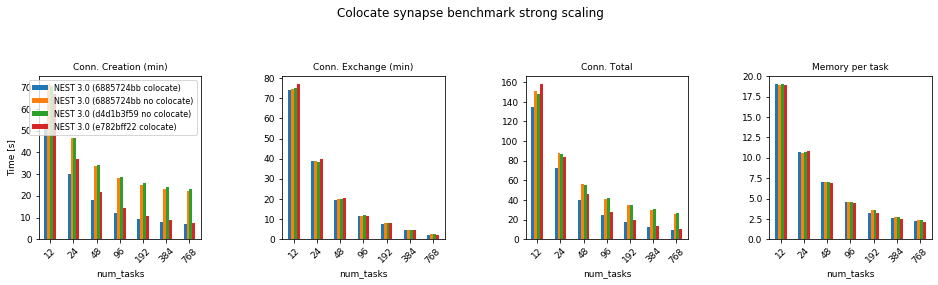

In [12]:
colocate_strong_68 = pd.read_csv('results/colocate/colocate_synapse_benchmark_6885724bb_daint_strong_scaling.csv')
colocate_strong_68['Case'] = ['NEST 3.0 (6885724bb colocate)'] * len(colocate_strong_68)

colocate_strong_e7 = pd.read_csv('results/colocate/colocate_synapse_benchmark_e782bff22_daint_strong_scaling.csv')
colocate_strong_e7['Case'] = ['NEST 3.0 (e782bff22 colocate)'] * len(colocate_strong_e7)

no_colocate_strong_68 = pd.read_csv('results/colocate/colocate_synapse_benchmark_6885724bb_no_colocate_daint_strong_scaling.csv')
no_colocate_strong_68['Case'] = ['NEST 3.0 (6885724bb no colocate)'] * len(no_colocate_strong_68)

no_colocate_strong_d4 = pd.read_csv('results/colocate/colocate_synapse_benchmark_d4d1b3f59_no_colocate_daint_strong_scaling.csv')
no_colocate_strong_d4['Case'] = ['NEST 3.0 (d4d1b3f59 no colocate)'] * len(no_colocate_strong_d4)

colocate_strong = pd.concat([colocate_strong_68, colocate_strong_e7, no_colocate_strong_68, no_colocate_strong_d4])

colocate_strong['Conn. Creation (min)'] = 0
colocate_strong = calculate_T_conn_and_memory(colocate_strong)

colocate_strong['Memory per task'] = (colocate_strong['VSize_sum']/colocate_strong['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
colocate_strong_p = plot_compare(colocate_strong, 'figures/colocate/colocate_synapse_benchmark_strong_scaling.pdf',
                                 values=values,
                                 index='num_tasks', plot_T_sim=False, legend_loc='upper right',
                                 title='Colocate synapse benchmark strong scaling')

colocate_strong_p

## Spatial colocate benchmark, strong scaling

Conn. Creation (min)                                   \
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (6885724bb no colocate)   
num_tasks                                                                  
12                           365.217770                       317.510884   
24                           195.988331                       155.453608   
48                           103.556113                        88.749129   
96                            56.374039                        55.347449   
192                           35.272787                        41.106854   
384                           23.626117                        33.126907   
768                           18.465254                        31.376787   

                   Conn. Exchange (min)                                   \
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (6885724bb no colocate)   
num_tasks                                                                  
12                            78.844408                        79.220559   
24                            39.525704                        39.489030   
48                            20.590743                        20.556546   
96                            11.657470                        11.802132   
192                            8.383666                         8.414189   
384                            4.329359                         4.613825   
768                            2.268194                         2.531874   

                            Conn. Total                                   \
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (6885724bb no colocate)   
num_tasks                                                                  
12                           444.673276                       397.743115   
24                           235.925234                       195.282583   
48                           124.373209                       109.484186   
96                            68.154206                        67.248341   
192                           43.730249                        49.583871   
384                           28.006014                        37.787117   
768                           20.769724                        33.946545   

                        Memory per task                                   
Case      NEST 3.0 (6885724bb colocate) NEST 3.0 (6885724bb no colocate)  
num_tasks                                                                 
12                            22.111680                        20.945602  
24                            11.540044                        10.844304  
48                             6.773633                         6.453158  
96                             4.541935                         4.402750  
192                            3.776963                         3.696301  
384                            2.780437                         2.775441  
768                            2.316195                         2.394482

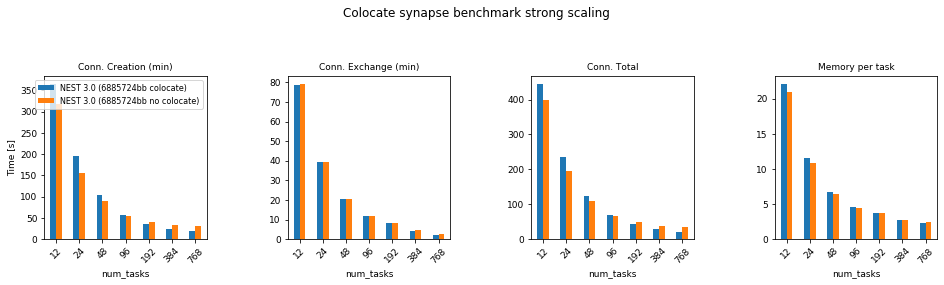

In [11]:
cl_sptl_strng_e7 = pd.read_csv('results/colocate/colocate_synapse_benchmark_e782bff22_spatial_daint_strong_scaling.csv')
cl_sptl_strng_e7['Case'] = ['NEST 3.0 (6885724bb colocate)'] * len(cl_sptl_strng_e7)

ncl_sptl_strng_e7 = pd.read_csv('results/colocate/colocate_synapse_benchmark_e782bff22_no_colocate_spatial_daint_strong_scaling.csv')
ncl_sptl_strng_e7['Case'] = ['NEST 3.0 (6885724bb no colocate)'] * len(ncl_sptl_strng_e7)

cl_sptl_strong = pd.concat([cl_sptl_strng_e7, ncl_sptl_strng_e7])

cl_sptl_strong['Conn. Creation (min)'] = 0
cl_sptl_strong = calculate_T_conn_and_memory(cl_sptl_strong)

cl_sptl_strong['Memory per task'] = (cl_sptl_strong['VSize_sum']/cl_sptl_strong['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
cl_sptl_strong_p = plot_compare(cl_sptl_strong, 'figures/colocate/colocate_synapse_benchmark_strong_scaling.pdf',
                                values=values,
                                index='num_tasks', plot_T_sim=False, legend_loc='upper right',
                                title='Colocate synapse benchmark strong scaling')

cl_sptl_strong_p